# A classification task using TDA

## Preparing the dataset

In [1]:
import matplotlib.pyplot as plt
import numpy as np

We are using the CIFAR10 dataset. As explained in its [readme](http://www.cs.toronto.edu/~kriz/cifar.html), it consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. The dataset is divided into five training batches and one test batch, each with 10000 images.

Once loaded, we obtain a dictionary with

* **data**: a 10000x3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.

* **labels**: a list of 10000 numbers in the range 0-9. The number at index i indicates the label of the ith image in the array data.


In [2]:
#We are loading the data as proposed in the readme
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [3]:
training_1_path = 'cifar-10-py-original/data/data_batch_1'
training_1_dict = unpickle(training_1_path)

training_2_path = 'cifar-10-py-original/data/data_batch_2'
training_2_dict = unpickle(training_2_path)

training_3_path = 'cifar-10-py-original/data/data_batch_3'
training_3_dict = unpickle(training_3_path)

training_4_path = 'cifar-10-py-original/data/data_batch_4'
training_4_dict = unpickle(training_4_path)

training_5_path = 'cifar-10-py-original/data/data_batch_5'
training_5_dict = unpickle(training_5_path)

test_path = 'cifar-10-py-original/data/test_batch'
test_dict= unpickle(test_path)

We are merging all training images together to make the computations easier

In [4]:
training_1_list = training_1_dict[b'data']
training_2_list = training_2_dict[b'data']
training_3_list = training_3_dict[b'data']
training_4_list = training_4_dict[b'data']
training_5_list = training_5_dict[b'data']
training_list = np.vstack([training_1_list, training_2_list, training_3_list,
                           training_4_list, training_5_list])

training_1_labels = training_1_dict[b'labels']
training_2_labels = training_2_dict[b'labels']
training_3_labels = training_3_dict[b'labels']
training_4_labels = training_4_dict[b'labels']
training_5_labels = training_5_dict[b'labels']
training_labels = (training_1_labels + training_2_labels + training_3_labels +
                   training_4_labels + training_5_labels)

Same procedure for the test images

In [5]:
test_list = test_dict[b'data']
test_labels = test_dict[b'labels']

In order to visualise the images, we need a small function to transform each row into a [skimage format](https://scikit-image.org/docs/dev/user_guide/numpy_images.html#color-images)

In [6]:
def row2matrix(image):
    """
    take a 1x3072 or 1x1024 numpy array representing a color/grey image and reshape it to the
    32x32 format used by scikit-image.
    """
    image_sk = np.zeros([32,32,3], dtype=int)
    for i in range(len(image)):
        x = (i//32)%32
        y = i%32
        z = i//1024
        image_sk[x,y,z]=image[i]
    return image_sk

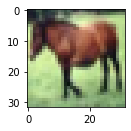

In [7]:
#Example of picture with label 7, "horse"
skimage = row2matrix(training_list[7])
plt.figure(figsize=(2.4,1.8))
plt.imshow(skimage)
plt.show()

To make the experiment simpler, we are only distinguishing two type of images: horses (tag 7) and ships (tag 8)

In [8]:
indexes = list(filter(lambda i : (training_labels[i]==7)|(training_labels[i]==8), range(len(training_labels))))
training_labels = [training_labels[i] for i in indexes]
training_list = training_list[indexes,:]

indexes = list(filter(lambda i : (test_labels[i]==7)|(test_labels[i]==8), range(len(test_labels))))
test_labels = [test_labels[i] for i in indexes]
test_list = test_list[indexes,:]

We will use a sub-level set filtration on grey scale images. Then, the next step is to transform color images into grey scale. We follow the [proposed method](https://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_rgb_to_gray.html) by scikit-image.

In [9]:
def color2grey(image):
    """
    take a 1x3072 numpy array representing a color image and gives a 1x1024
    numpy array of integers representing a grey scale image.
    """
    r = image[0:1024]
    g = image[1024:2048]
    b = image[2048:3072]
    #Weighted average of the intensities which produce a nice-viewing gray 
    #scale image.
    grey = 0.2125*r + 0.7154*g + 0.0721*b
    grey = np.array(list(map(lambda x : int(x), grey)))
    return grey

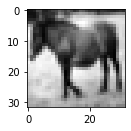

In [10]:
#The same image, in grey scale
skimage = row2matrix(color2grey(training_list[0]))[:,:,0]
plt.figure(figsize=(2.4,1.8))
plt.imshow(skimage, cmap=plt.cm.gray)
plt.show()

We also need to transpose the image to adapt it to the gudhi input format.

In [11]:
#The row order from the database CIFAR-10 is the transpose respect to the
#one of gudhi. The following functions transform one into the other.
def row_transpose(image):
    """
    Take a 1x1024 int row and change its order to represent the transpose 
    image.
    """
    transpose = np.zeros([1024], dtype=int)
    for i in range(1024):
        x = i//32
        y = i%32
        transpose[y*32+x]=image[i]
    return transpose

We apply all this changes to generate the training and test inputs for gudhi

In [12]:
training_gudhi = map(color2grey, training_list)
training_gudhi = map(row_transpose, training_gudhi)
training_gudhi = np.array(list(training_gudhi))

test_gudhi = map(color2grey, test_list)
test_gudhi = map(row_transpose, test_gudhi)
test_gudhi = np.array(list(test_gudhi))

## Calculating the persistence diagrams and landscapes

In [13]:
import gudhi as gd
import gudhi.representations

In this simple example, we are using the 1 dimensional landscape as or vectorisation map. Then, we need to calculate the cubical complexes with the sublevel set filtration from each image, and then its persistent homology. We use the the calculate_pd function.

In [14]:
cub_filtration = lambda image : gd.CubicalComplex(dimensions = [32,32], top_dimensional_cells=image)
calculate_pd = lambda image : cub_filtration(image).persistence()

training_pds = map(calculate_pd, training_gudhi)
test_pds = map(calculate_pd, test_gudhi)

I was not able to use the gudhi's function persistence_intervals_in_dimension(), so I had to write a new one called intervals_of_dim_1. We should check out this error for future experiments.

In [15]:
intervals_of_dim_1 = lambda pd : np.array([[x[1][0], x[1][1]]  for x in pd if x[0]==1])
training_pds_1 = list(map(intervals_of_dim_1, training_pds))
test_pds_1 = list(map(intervals_of_dim_1, test_pds))

The [representations](https://gudhi.inria.fr/python/3.1.0.rc1/representations.html) module is compatible with sklearn. We use it to calculate the persistence landscapes. The module supports many other vectorisation methods. 

In [16]:
LS = gd.representations.Landscape(resolution=1000)
training_LS = LS.fit_transform(training_pds_1)
test_LS = LS.fit_transform(test_pds_1)

The default settings draw 5 landscapes in a row with parameters $k=1\ldots5$ (I am not 100% sure, I had to deduce it from the [source code](https://gudhi.inria.fr/python/latest/_modules/gudhi/representations/vector_methods.html#Landscape.__init__)).

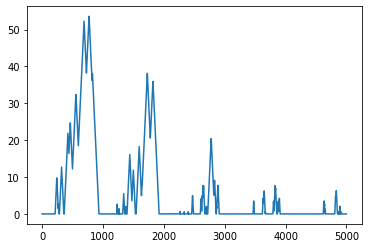

In [17]:
plt.plot(training_LS[0])

## Random Forest Classification

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

We are performing a simple classification task using Random Forest. Training the classifier is quite convenient once we have the right input for sklearn.

In [19]:
classifier = RandomForestClassifier()
classifier = classifier.fit(training_LS, training_labels)   

In this example, the accuracy is the following

In [20]:
print("Train accuracy = " + str(classifier.score(training_LS, training_labels)))
print("Test accuracy  = " + str(classifier.score(test_LS, test_labels))) 

Train accuracy = 1.0
Test accuracy  = 0.689


## Cross validation for method and parameter selection

In [21]:
from sklearn.preprocessing   import MinMaxScaler
from sklearn.pipeline        import Pipeline
from sklearn.svm             import SVC
from sklearn.model_selection import GridSearchCV

We would like to compare many different vectorisation methods and parameters. Here, we create a pipeline with different parameters and use GridSearchCV with 5-fold cross validation to find the best estimator between all possibilities. We follow this [tutorial](https://github.com/GUDHI/TDA-tutorial/blob/master/Tuto-GUDHI-representations.ipynb). 

In [22]:
# I do not understand why we have to set PI for "TDA" neither an "Estimator" as a RandomForestClassifier
# I guess it is needed to add one especific method to later change it as a parameter
pipe = Pipeline([("Separator", gd.representations.DiagramSelector(limit=np.inf, point_type="finite")),
                 ("Scaler",    gd.representations.DiagramScaler(scalers=[([0,1], MinMaxScaler())])),
                 ("TDA",       gd.representations.PersistenceImage()),
                 ("Estimator", RandomForestClassifier())])

In [23]:
# Parameters of pipeline. This is the place where you specify the methods you want to use
param =    [{"Scaler__use":         [True],
             "TDA":                 [gd.representations.PersistenceImage()], 
             "TDA__resolution":     [ [5,5], [6,6] ],
             "TDA__bandwidth":      [0.01, 0.1, 1.0, 10.0],
             "Estimator":           [SVC(), RandomForestClassifier()]},
            
            {"Scaler__use":         [True],
             "TDA":                 [gd.representations.Landscape()], 
             "TDA__resolution":     [100],
             "Estimator":           [SVC(), RandomForestClassifier()]},
            
            {"Scaler__use":         [True],
             "TDA":                 [gd.representations.BettiCurve()], 
             "TDA__resolution":     [100],
             "Estimator":           [SVC(), RandomForestClassifier()]}
           ]

In [24]:
model = GridSearchCV(pipe, param, cv=5)
model = model.fit(training_pds_1, training_labels)

In [25]:
print("The method and parameters with the best accuracy are ")
print()
print(model.best_params_)

The method and parameters with the best accuracy are 

{'Estimator': SVC(), 'Scaler__use': True, 'TDA': PersistenceImage(bandwidth=0.1, resolution=[6, 6]), 'TDA__bandwidth': 0.1, 'TDA__resolution': [6, 6]}


In [26]:
print("Train accuracy = " + str(model.score(training_pds_1, training_labels)))
print("Test accuracy  = " + str(model.score(test_pds_1,  test_labels)))

Train accuracy = 0.7373
Test accuracy  = 0.719


We can also extract the complete list whith the scores for each selection of parameters 

In [27]:
results = model.cv_results_
for mean_score, params in zip(results["mean_test_score"], results["params"]):
    print(mean_score, params)

0.5583 {'Estimator': SVC(), 'Scaler__use': True, 'TDA': PersistenceImage(bandwidth=0.1, resolution=[6, 6]), 'TDA__bandwidth': 0.01, 'TDA__resolution': [5, 5]}
0.5622 {'Estimator': SVC(), 'Scaler__use': True, 'TDA': PersistenceImage(bandwidth=0.1, resolution=[6, 6]), 'TDA__bandwidth': 0.01, 'TDA__resolution': [6, 6]}
0.7214 {'Estimator': SVC(), 'Scaler__use': True, 'TDA': PersistenceImage(bandwidth=0.1, resolution=[6, 6]), 'TDA__bandwidth': 0.1, 'TDA__resolution': [5, 5]}
0.7271 {'Estimator': SVC(), 'Scaler__use': True, 'TDA': PersistenceImage(bandwidth=0.1, resolution=[6, 6]), 'TDA__bandwidth': 0.1, 'TDA__resolution': [6, 6]}
0.6719 {'Estimator': SVC(), 'Scaler__use': True, 'TDA': PersistenceImage(bandwidth=0.1, resolution=[6, 6]), 'TDA__bandwidth': 1.0, 'TDA__resolution': [5, 5]}
0.6718 {'Estimator': SVC(), 'Scaler__use': True, 'TDA': PersistenceImage(bandwidth=0.1, resolution=[6, 6]), 'TDA__bandwidth': 1.0, 'TDA__resolution': [6, 6]}
0.6685000000000001 {'Estimator': SVC(), 'Scaler__u